In [2]:
from model import CNN
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
CHANNELS_D = 3

img_size = 400
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "model.pth"
data_dir = "~/Documents/datasets/archive/caltech101_classification/"

classes = ["Motorcycle", "Airplane", "Schooner"]

In [2]:
def norm_transforms(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(root=dir, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unorm

norm, unorm = norm_transforms(data_dir)

In [3]:
def load_data(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(
        root=dir,
        transform=transform)

    train_size = int(0.6 * len(dataset))
    test_val_size = len(dataset) - train_size
    train_data, test_val_data = torch.utils.data.random_split(dataset, [train_size, test_val_size])

    val_size = int(0.5 * len(test_val_data))
    test_size = len(test_val_data) - val_size
    val_data, test_data = torch.utils.data.random_split(test_val_data, [val_size, test_size])
    
    return train_data, val_data, test_data
train_data, val_data, test_data = load_data("~/Documents/datasets/archive/caltech101_classification/")

### My attempt at CNNs

In [4]:
class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.net = self.gen_layers(self.num_layers, self.expansion)
    def gen_layers(self, num_layers, expansion):
        layers = []
        in_channels = 3
        
        # use batchnorm to prevent over/under shooting
        for i in range(num_layers):
            out_channels = expansion(in_channels)
            # out_channels = expansion * in_channels
            layers += [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)]
            layers += [nn.ReLU(), nn.BatchNorm2d(out_channels, affine=False)]
            layers += [nn.MaxPool2d(2, 2)]
            in_channels = out_channels

        # num params
        # print(((img_size // (2 ** num_layers)) ** 2) * in_channels)
        fcl = ((img_size // (2 ** num_layers)) ** 2) * in_channels
        layers += [nn.Flatten(1), nn.BatchNorm1d(fcl, affine=False), nn.Linear(fcl, 256)]
        layers += [nn.ReLU(), nn.Linear(256, 3), nn.ReLU()]
        
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [5]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += pred.item() == label
        return correct, round((correct / len(data) * 100), 3)

In [6]:
def train(model, train_data, batch, epochs, lr):
    CHANNELS_D = 3

    loader = DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=2)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    epoch_data = []
    for epoch in range(epochs + 1):
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(tqdm(loader)):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        _, train_acc = eval(model, train_data)
        _, val_acc = eval(model, val_data)
        model.train()
        
        print(f'epoch: {epoch + 1} loss: {running_loss / batch:.6f}')
        epoch_data.append((epoch, float(f"{(running_loss / batch):.6f}"), train_acc, val_acc))
        running_loss = 0.0
    
    return epoch_data

def save(model, path):
    torch.save(model.state_dict(), path)

In [7]:
def sample(model, test_data):
    with torch.no_grad():
        figure = plt.figure(figsize=(10, 8))
        cols, rows = 4, 4
        correct = 0

        for i in range(1, cols * rows + 1):
            rand = torch.randint(len(test_data), size=(1,)).item()
            img, label = test_data[rand]
            img_input = img.to(device).unsqueeze(0)

            figure.add_subplot(rows, cols, i)
            img = unorm(img)
            npimg = np.transpose(img.numpy(), (1, 2, 0))

            plt.title(f"({i}) {classes[label]}")
            plt.axis("off",)
            plt.imshow((npimg * 255).astype(np.uint8))

            pred = model(img_input).to('cpu')

            _, pred = torch.max(pred.squeeze(), 0)
    
            print(f"({i}) Prediction: {classes[pred.item()]}, Actual: {classes[label]}")
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n {correct} / {cols * rows} correct -> {correct / (cols * rows) * 100} %")
        plt.show()

In [8]:
expansions = []
lrs = [1e-4, 2e-3, 35e-4, 0.01]
num_layers = 4
batch_size = 100
num_epochs = 20
# recursive expressions to use for expanding feature map from conv layer (number of kernels)
expansions.append(lambda x: x + 13)
expansions.append(lambda x: x*2 if x < 20 else x + (x // 2))
expansions.append(lambda x: x*3 if x < 50 else x + (x // 6))


In [ ]:
# use data loader for eval func to use batches
# speed up train time

def test_networks():
    runs = []
    
    for n in range(num_layers):
        for expr in expansions:
            model = CNN(n + 1, expr).to(device)
            epoch_data = train(model, train_data, batch=batch_size, epochs=num_epochs, lr=lrs[n])
            print("evaluating...")
            model.eval() # set eval for batch norm bc batch size is only 1
            _, accuracy = eval(model, val_data)
            runs.append((n, expr, accuracy, epoch_data))
            del model

    return runs
runs = test_networks()

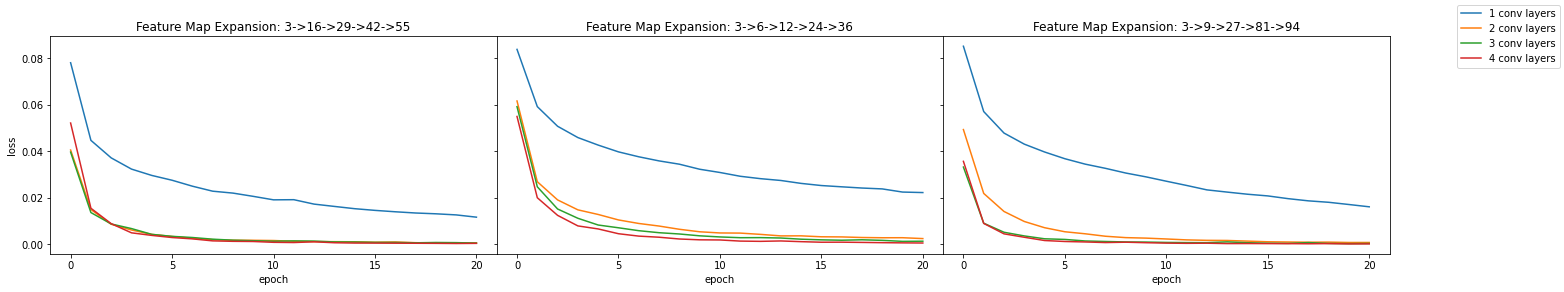

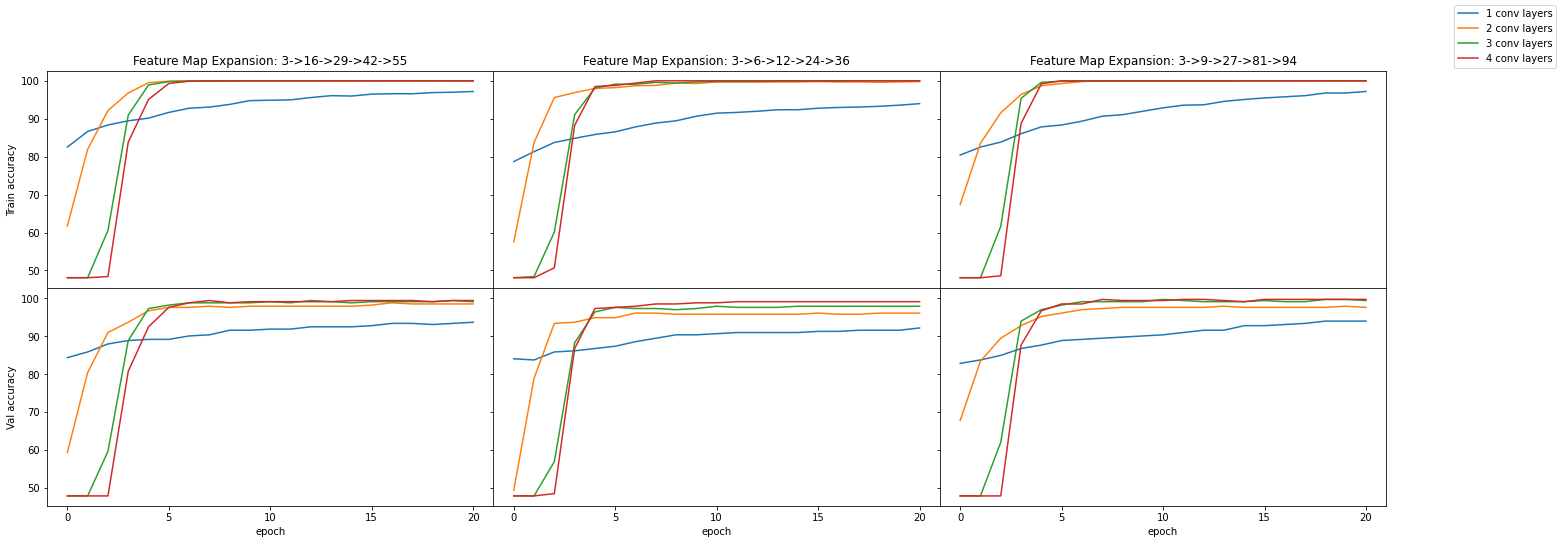

In [10]:
def str_conv_seq(expr, n_lay):
    prior = CHANNELS_D
    conv_seq = str(prior)
    for i in range(n_lay + 1):
        prior = expr(prior)
        conv_seq += f"->{str(prior)}"
    return conv_seq

def plot_losses(runs):
    fig, axs = plt.subplots(1, len(expansions), figsize=(24,4),
        gridspec_kw={'wspace': 0}, sharey=True)

    axs[0].set(ylabel="loss")
    for (n_lay, expr, accuracy, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]
        axs[c].set_title("Feature Map Expansion: " + conv_seq)
        if c == len(expansions) - 1:
            axs[c].plot(train_info[0], train_info[1], label=f"{n_lay + 1} conv layers")    
        else:
            axs[c].plot(train_info[0], train_info[1])

    for ax in axs:
        ax.set(xlabel="epoch")
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

def plot_accuracies(runs):
    fig, axs = plt.subplots(2, len(expansions), figsize=(24,8),
        gridspec_kw={'hspace': 0, 'wspace': 0}, sharey=True)

    axs[0, 0].set(ylabel='Train accuracy')
    axs[1, 0].set(ylabel='Val accuracy')
    for (n_lay, expr, accuracy, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]

        if c == len(expansions) - 1:
            axs[0, c].plot(train_info[0], train_info[2], label=f"{n_lay + 1} conv layers") 
        else:
            axs[0, c].plot(train_info[0], train_info[2])
        
        axs[0, c].set_title("Feature Map Expansion: " + conv_seq)
        axs[1, c].plot(train_info[0], train_info[3])

    for ax in axs[1, :]:
        ax.set(xlabel="epoch")
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

  
plot_losses(runs)
plot_accuracies(runs)


In [11]:
def print_acc():
    for (n_lay, expr, accuracy, _) in runs:
        conv_seq = str_conv_seq(expr, n_lay)
        print(f"{conv_seq} accuracy: {accuracy}%")
        
print_acc()

3->16 accuracy: 93.675%
3->6 accuracy: 92.169%
3->9 accuracy: 93.976%
3->16->29 accuracy: 98.494%
3->6->12 accuracy: 96.084%
3->9->27 accuracy: 97.59%
3->16->29->42 accuracy: 99.096%
3->6->12->24 accuracy: 97.892%
3->9->27->81 accuracy: 99.398%
3->16->29->42->55 accuracy: 99.398%
3->6->12->24->36 accuracy: 99.096%
3->9->27->81->94 accuracy: 99.699%


In [ ]:
model = CNN(num_layers, expansions[2]).to(device)
num_epochs = 30
epoch_data = train(
    model, train_data, batch=batch_size, epochs=num_epochs, lr=lrs[3])

In [88]:
def count_params(model: CNN):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_incorrect(model, data):
    with torch.no_grad():
        incorrect = []
        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            if pred.item() != label:
                incorrect.append((img, label, pred))
                
    return incorrect

def show_incorrect(incorrect):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 2, len(incorrect) // 2 + 1
    correct = 0

    for i, (img, label, pred_label) in enumerate(incorrect):
        figure.add_subplot(rows, cols, i + 1)
        img = unorm(img).to("cpu")
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        plt.title(f"actual: {classes[label]} pred: {classes[pred_label]}")
        plt.axis("off",)
        plt.imshow((npimg * 255).astype(np.uint8))

In [ ]:
model.eval()
correct, acc = eval(model, val_data)
show_incorrect(get_incorrect(model, val_data))
print(f"{correct} out of {len(val_data)} correct \
    accuracy: {acc}%")

### save best model here 

### VGGNet implementation

paper: https://arxiv.org/abs/1409.1556

![vgg_arch.png](./vgg_arch.png)

In [3]:
class VGG(nn.Module):
    def __init__(self, net_config):
        super().__init__()
        self.configs = {
            'A': [1, 1, 2, 2, 2],
            'B': [2, 2, 2, 2, 2],
            'C': [2, 2, 3, 3, 3], # make sure to check C for k size
            'D': [2, 2, 3, 3, 3],
            'E': [2, 2, 4, 4, 4]
        }
        self.net = self.gen_layers(net_config)
    def gen_layers(self, net_config):
        layers = [], num_layers = self.configs['A']
        in_channel = CHANNELS_D

        for i, n in enumerate(num_layers):
            transition = n != num_layers[i + 1] and n != num_layers[-1]
            kernel = (1, 1) if net_config == "C" and transition else (3, 3)
            layers.append(nn.Conv2d(in_channel, 64 * n, kernel))
            if transition:
                layers.append(nn.MaxPool2d((2,2), (2,2)))
            in_channel = 64 * n
            
        
        # layers += [
        #     nn.Linear(_, 4096),
        #     nn.ReLU(),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(),
        #     nn.Linear(4096, 3)
        # ]

        return nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

### ? GooglNet implementation

### ? ResNet implementation

### Overall evaluation

### Conclusion